<a href="https://colab.research.google.com/github/gautamankitkumar/ankitgau-ms-report-data/blob/main/notebooks/train-BPNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Goal

We trained a machine learning model based on Behler Parinello Neural Network framework as outlined in [Behler and Parinello 2007](https://doi.org/10.1103/PhysRevLett.98.146401).


## Method

In [ ]:
! pip install ase
! pip install torch==1.7.0+cpu torchvision==0.8.1+cpu torchaudio==0.7.0 -f https://download.pytorch.org/whl/torch_stable.html

In [ ]:
! git clone https://github.com/gautamankitkumar/ankitgau-ms-report-data.git

In [1]:
% cd ankitgau-ms-report-data
% cd notebooks
% cd utils
! python3 libsymf_builder.py
% cd .. # Finally in notebooks directory

UsageError: Line magic function `%` not found.


In [5]:
import os
import torch
import numpy as np
from ase.db import connect
from utils.fcc_helpers import cal_nrg
from utils.train_agent import BPNN
from utils.fp_calculator import set_sym
from ase.build import fcc111
import matplotlib.pyplot as plt
from utils.fp_calculator import set_sym, db_to_fp
from utils.train_agent import Agent, get_scaling
os.environ['KMP_DUPLICATE_LIB_OK']='True'

m = 1
n = 4000
np.random.seed(seed=42)

full_data = connect('./datasets/CuAgAu.db')

if os.path.exists('./datasets/test.db'):
    os.remove('./datasets/test.db')
if os.path.exists('./datasets/train.db'):
    os.remove('./datasets/train.db')
if os.path.exists('./datasets/valid.db'):
    os.remove('./datasets/valid.db')


train_data = connect('./datasets/train.db')
valid_data = connect('./datasets/valid.db')
test_data = connect('./datasets/test.db')

In [3]:
#  Generate different train and test dataset
valid_and_test_ids = np.random.choice(np.arange(1,n),n//5,replace=False)

valid_ids = valid_and_test_ids[:n//10]
test_ids = valid_and_test_ids[n//10:]

In [4]:
for i in range(1,n+1):
    if i%100==0:
        print(i)
    row = full_data.get_atoms(selection = i)
    if i in test_ids:
        test_data.write(row)
    elif i in valid_ids:
        valid_data.write(row)
    else:
        train_data.write(row)

100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000


In [14]:
Name = 'CuAgAu'
elements = ['Cu', 'Ag', 'Au']

Gs = [2]
cutoff = 6.0
g2_etas = [0.05, 4.0, 20.0, 80.0]
g2_Rses = [0.0]

params_set = set_sym(elements, Gs, cutoff, g2_etas=g2_etas, g2_Rses=g2_Rses)


# calculate fingerprints for databases
train_db = connect('./datasets/train.db')
train_data = db_to_fp(train_db, params_set)
torch.save(train_data, f'./{Name}/CuAgAu-train-dft.sav')

valid_db = connect('./datasets/valid.db')
valid_data = db_to_fp(valid_db, params_set)
torch.save(valid_data, f'./{Name}/CuAgAu-valid-dft.sav')

test_db = connect('./datasets/test.db')
test_data = db_to_fp(test_db, params_set)
torch.save(test_data, f'./{Name}/CuAgAu-test-dft.sav')

# load data
train_data = torch.load(f'./{Name}/CuAgAu-train-dft.sav')
valid_data = torch.load(f'./{Name}/CuAgAu-valid-dft.sav')
test_data = torch.load(f'./{Name}/CuAgAu-test-dft.sav')
scale_file = f'./{Name}/scale.sav'

if not os.path.isfile(scale_file):
    scale = get_scaling(train_data)
    torch.save(scale, scale_file)
else:
    scale = torch.load(scale_file)

# scale training fp
train_data['b_fp'] = (train_data['b_fp'] - scale['fp_min']) / (scale['fp_max'] - scale['fp_min'])
valid_data['b_fp'] = (valid_data['b_fp'] - scale['fp_min']) / (scale['fp_max'] - scale['fp_min'])
test_data['b_fp'] = (test_data['b_fp'] - scale['fp_min']) / (scale['fp_max'] - scale['fp_min'])

device = torch.device('cpu')
# for key in train_data.keys():
# 	train_data[key] = train_data[key].to(device)
# 	valid_data[key] = valid_data[key].to(device)

layer_nodes = [10,10]
activations = ['tanh','tanh']
lr = 0.1

# create model and train
element = torch.tensor([29, 47, 79])  # should have the same order with the elements above
model_paths = [f'./{Name}/model_for_{i}.sav' for i in element.tolist()]
log_name = f'./{Name}/train_log.txt'

agent = Agent(train_data=train_data, valid_data=valid_data, model_paths=model_paths, test_data=test_data,
              layer_nodes=layer_nodes,
              activation=activations, lr=lr, max_iter=20, history_size=100, device=device)

agent.train(log_name=log_name, n_epoch=50, interupt=True, val_interval=1,
            is_force=False, nrg_convg=2, force_convg=20, nrg_coef=1, force_coef=1)
# Energy convergence in meV, Force convergence in meV/Angstrom
# No Force fitting from the data

validation: epoch: 0, nrg_mae: 207.437744140625 meV/atom, force_mae: 0 meV/AA
validation: epoch: 1, nrg_mae: 52.57503128051758 meV/atom, force_mae: 0 meV/AA
validation: epoch: 2, nrg_mae: 31.27016830444336 meV/atom, force_mae: 0 meV/AA
validation: epoch: 3, nrg_mae: 19.340782165527344 meV/atom, force_mae: 0 meV/AA
validation: epoch: 4, nrg_mae: 15.267087936401367 meV/atom, force_mae: 0 meV/AA
validation: epoch: 5, nrg_mae: 14.425921440124512 meV/atom, force_mae: 0 meV/AA
validation: epoch: 6, nrg_mae: 13.544113159179688 meV/atom, force_mae: 0 meV/AA
validation: epoch: 7, nrg_mae: 11.575052261352539 meV/atom, force_mae: 0 meV/AA
validation: epoch: 8, nrg_mae: 9.878355026245117 meV/atom, force_mae: 0 meV/AA
validation: epoch: 9, nrg_mae: 9.179671287536621 meV/atom, force_mae: 0 meV/AA
validation: epoch: 10, nrg_mae: 8.500082969665527 meV/atom, force_mae: 0 meV/AA
validation: epoch: 11, nrg_mae: 7.028116226196289 meV/atom, force_mae: 0 meV/AA
validation: epoch: 12, nrg_mae: 6.306750297546

In [15]:
# load models and symmetry functions
Name = 'CuAgAu'
scale = torch.load(f'./{Name}/scale.sav')
layer_nodes = [10,10]
activations = ['tanh', 'tanh']
elements_i = [29, 47, 79]
n_fp = 12
models = [BPNN(n_fp, layer_nodes, activations) for _ in elements_i]
model_paths = [f'./{Name}/model_for_{i}.sav' for i in elements_i]
for i in range(len(models)):
    models[i].load_state_dict(torch.load(model_paths[i], map_location=torch.device('cpu')))

# set symm func parameters
elements = ['Cu', 'Ag', 'Au']  # [1, 2, 3 in the param_set]
Gs = [2]
cutoff = 6.0
g2_etas = [0.05, 4.0, 20.0, 80.0]
g2_Rses = [0.0]
# g4_etas = [0.005]
# g4_zetas = [1.0, 4.0]
# g4_lambdas = [-1.0, 1.0]

params_set = set_sym(elements, Gs, cutoff, g2_etas=g2_etas, g2_Rses=g2_Rses)

train_en = []
test_en = []
valid_en = []
for i in range(m,n+1):
    if i%200==0:
        print(i)
    atoms = full_data.get_atoms(selection=i)
    ans = cal_nrg(models, atoms, params_set, elements, scale)
    X = atoms.get_atomic_numbers().tolist()
        
    if i in test_ids:
        test_en.append([i,(atoms.get_potential_energy()-ans)/len(atoms)])
    elif i in valid_ids:
        valid_en.append([i,(atoms.get_potential_energy()-ans)/len(atoms)])
    else:
        train_en.append([i,(atoms.get_potential_energy()-ans)/len(atoms)])

200
400
600
800
1000
1200
1400
1600
1800
2000
2200
2400
2600
2800
3000
3200
3400
3600
3800
4000


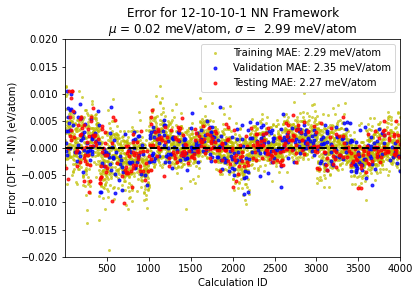

In [16]:
# plot it
train_en = np.array(train_en)
test_en = np.array(test_en)
valid_en = np.array(valid_en)
hist_en = np.concatenate((train_en[:,1],test_en[:,1],valid_en[:,1]))
f = plt.figure()

plt.plot(train_en[:,0],train_en[:,1],'y.',lw=1,alpha=0.7,markeredgewidth=0)
plt.xlabel('Calculation ID')
plt.ylabel('Error (DFT - NN) (eV/atom)')
plt.title('Error for 12-'+ '-'.join([str(x) for  x in layer_nodes]) + '-1 NN Framework\n' +  r'$\mu$ = '+f'{np.mean(hist_en)*1000:.2f} meV/atom, '+r'$\sigma$ =  '+f'{np.std(hist_en)*1000:.2f} meV/atom')
plt.xlim([m,n])
plt.ylim([-0.02,0.02])
plt.plot(valid_en[:,0],valid_en[:,1],'b.',lw=1,alpha=0.8)
plt.plot(test_en[:,0],test_en[:,1],'r.',lw=1,alpha=0.8)
plt.axhline(0,color='k',ls='dashed',lw=2)
plt.legend([f'Training MAE: { np.mean(np.abs(train_en[:,1]))*1000:.2f} meV/atom',
           f'Validation MAE: {np.mean(np.abs(valid_en[:,1]))*1000:.2f} meV/atom',
           f'Testing MAE: {   np.mean(np.abs(test_en [:,1]))*1000:.2f} meV/atom'])

plt.show()